In [15]:
import importlib
from pathlib import Path
import shutil
import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader, random_split
from torch import cuda, tensor, nn, optim
from torch.backends import mps
from torchvision import transforms

import matplotlib.pyplot as plt
from skimage import io
import numpy as np

import datasets.catdog_loader as catdog_loader
from ptmodels import bic_pytorch as bp

# Use a gpu or M1 chipset to train PyTorch networks if you have it.
if cuda.is_available():
    pt_device = 'cude'

elif mps.is_available():
    pt_device = 'mps'

else: 
    pt_device = 'cpu'

pt_device = 'cpu'
print(f'Using {pt_device}.')


Using cpu.


# Project One: Dog and Cat Classifier
The goal of this project is to use a kaggle dataset to train a dog and cat classifier.  The data consists of user images.  Because this is binary classification, we can probably get awayout one-hot encoding: $y(\mathbf{x}=f(\mathbf{x})$, where $\mathbf{x}$ is either a flattened image vector or an 2D image matrix and $f$ is the function we are trying to model with $y$ being the predicted label.  

Classifiers will be implemented using PyTorh.  The first will be a simple logistics classifier, the second a three-layer perceptron with `relu` activation functions for the hidden layers, and finally a ConvNet with a final linear layer feeding into a sigmoid activation function. 

The first thing we need to do is load the data and format it for training. 

In [4]:
data_path = Path('datasets') / 'kagglecatsanddogs_5340' / 'PetImages'
cat_path = data_path / 'Cat'
dog_path = data_path / 'Dog'
cat_img_names = list(cat_path.glob('*.jpg'))
dog_img_names = list(dog_path.glob('*.jpg'))

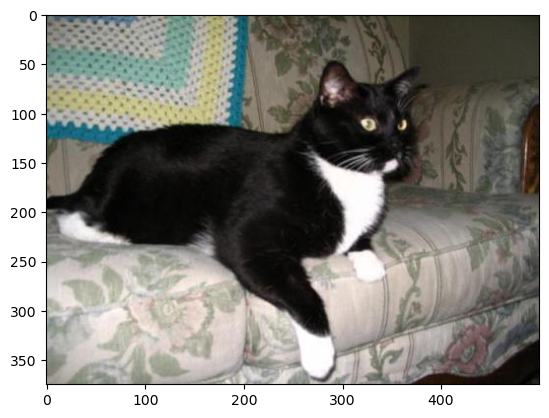

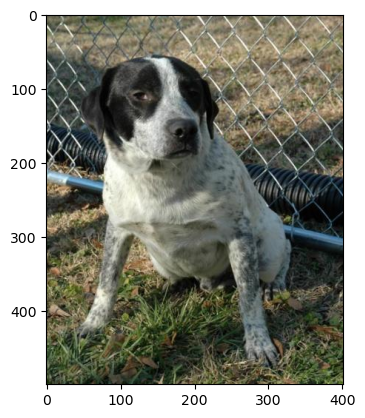

(375, 500, 3) (500, 401, 3)


In [5]:
# Let's load up some images. 
def get_image(fname):
    assert Path(fname).is_file()
    return np.asarray(io.imread(fname), dtype=int)

cat_test = cat_img_names[1]
dog_test = dog_img_names[1]

cat_test_img = get_image(cat_test)
dog_test_img = get_image(dog_test)

plt.imshow(cat_test_img)
plt.show()
plt.imshow(dog_test_img)
plt.show()

print(cat_test_img.shape, dog_test_img.shape)

Before training, we want to make sure loaded images will transform appropriately into `PyTorch` `Tensor` objects.   

Before training, let's move incompatible, corrupt, or bad images to two new directories: `PetImages/notused_cat` and `PetImages/notused_dog`.  It is good practice to not immediately delete problematic data -- for example, you can always come back to it and see if you can transform incompatible file types to increase your training set if you need to!  Remember that doing this once will make irreversible changes. 

Note: we are creating a `torchvision.transforms.ToTensor()` instance to make sure the loaded image arrays properly convert to `torch.Tensor` objects.  More on that later. 

In [8]:
# we are just going to script this workflow since it is a one-time thing. 

notused_cat_path = data_path / 'notused_cat'
notused_dog_path = data_path / 'notused_dog'

notused_cat_path.mkdir(exist_ok=True)
notused_dog_path.mkdir(exist_ok=True)

dont_use_cat = []
for f in cat_path.glob('*.jpg'):
    try:
        # First, we load an image and see if it fails.  If it does,
        # then we add it to the don't use list. 
        arr = io.imread(str(f))
        arr = transforms.ToTensor()(arr)


        # Also, if there are not three color channels, we also are 
        # going to move the file. Note that torchvision puts channels 
        # first.
        if arr.shape[0] != 3:
            dont_use_cat.append(f)
    
    except:
        print(f'{f} raised exception when read.  Skipping...')
        dont_use_cat.append(f)


dont_use_dog = []
for f in dog_path.glob('*.jpg'):
    try:
        # First, we load an image and see if it fails.  If it does,
        # then we add it to the don't use list. 
        arr = io.imread(str(f))
        arr = transforms.ToTensor()(arr)

        # Also, if there are not three color channels, we also are 
        # going to move the file. Note that torchvision puts channels 
        # first.
        if arr.shape[0] != 3:
            dont_use_dog.append(f)
    
    except:        
        print(f'{f} raised exception when read.  Skipping...')
        dont_use_dog.append(f)


datasets/kagglecatsanddogs_5340/PetImages/Cat/11565.jpg raised exception when read.  Skipping...
datasets/kagglecatsanddogs_5340/PetImages/Cat/10125.jpg raised exception when read.  Skipping...
datasets/kagglecatsanddogs_5340/PetImages/Cat/4833.jpg raised exception when read.  Skipping...
datasets/kagglecatsanddogs_5340/PetImages/Cat/2663.jpg raised exception when read.  Skipping...
datasets/kagglecatsanddogs_5340/PetImages/Cat/11210.jpg raised exception when read.  Skipping...
datasets/kagglecatsanddogs_5340/PetImages/Cat/11935.jpg raised exception when read.  Skipping...
datasets/kagglecatsanddogs_5340/PetImages/Cat/3491.jpg raised exception when read.  Skipping...
datasets/kagglecatsanddogs_5340/PetImages/Cat/5553.jpg raised exception when read.  Skipping...
datasets/kagglecatsanddogs_5340/PetImages/Cat/936.jpg raised exception when read.  Skipping...
datasets/kagglecatsanddogs_5340/PetImages/Cat/8470.jpg raised exception when read.  Skipping...
datasets/kagglecatsanddogs_5340/PetIm

In [9]:
len(dont_use_cat), len(dont_use_dog)

(25, 33)

In [10]:
# It can take a minute to go through all the image files.  Now we move them 
# to the new 'not used' directories.
for f in dont_use_cat:
    new_path = notused_cat_path / f.name
    shutil.copy(f, new_path)
    f.unlink() # easy way to remove a file located at the path 'f'. 

for f in dont_use_dog:
    new_path = notused_dog_path / f.name
    shutil.copy(f, new_path)
    f.unlink()

We have saved troublesome images to look at later if we are so obliged. Let's come back to loading the data set.  As mentioned, we are running into some design issues in our current implementation. Instead of implementing this functionality nearly from scratch, let's use PyTorch's DataSet and DataLoader classes.  The file `catdog_loader.py` contains a DataSet subclass `CatDogDataSet` which we can use to load up the data set. Note that `CatDogDataSet` using `scikit-image` instead of `torchvision` for file io --- numpy arrays are then transformed to `torch.tensor` opjects using `torchvision.ToTensor()`, which conveniently reformats image tensors to be channel-first (the PyTorch de facto standard) and normalizes counts from $(0,255)$ to $(0,1)$ for training. 

We can also feed `torchvision.transforms` transformations to chain image transformations together for our input image Tensors and outputs.  First, we are gonig to want to resize the images to be all the same input size --- specifically, we'll resize each image to $128\times128$ pixels per color channel.  This means each image will be a $3\times128\times128$ tensor.  Optionally, we code also convert to one-hot encoding (see commented out code below).

In [11]:
importlib.reload(catdog_loader)
pt_transforms = transforms.Compose(
    [transforms.Resize((128, 128), antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

data_pt = catdog_loader.CatDogDataSet(
    data_path, transform=pt_transforms
)

# If we want one-hot encoding, we could do this using the 'target_transform' kwarg.  Just make sure 
# to specify the number of classes for the encoding. A lambda function will work well to do that here. 
# data_pt = catdog_loader.CatDogDataSet(
#     data_path, transform=pt_transforms, target_transform=lambda x: nn.functional.one_hot(x, num_classes=2)
# )
    

Already, we see the advantage of not reinventing the wheel.  PyTorch and torchvision provide powerful tools to pre-process, load, and transform data.  Unless otherwise noted, they are tried modules with robust support.  We will stick with PyTorch IO for the remainder of this notebook. 

Next, we want to prepare the data set to be fed forward through the networks we will be using.  First, we are going to split the data into random subsamples --- one for training, the other for validating. Again, PyTorch makes this easy by providing an easy way to do this with `torch.utils.data.random_split`.  After that, we are going to prepare the data for network feed forward by using the `DataLoader` class.  It makes it easy to create random batches of specified size from a `DataSet` object (specifically, the `CatDogDataSet` object we wrote).   

In [12]:
data_train, data_valid = random_split(data_pt, [0.8, 0.2])
dataload_train = DataLoader(data_train, batch_size=128, shuffle=True)
dataload_valid = DataLoader(data_valid, batch_size=256, shuffle=True)

We are set to start training some networks.  Let's start with a PyTorch implementation of a single layer linear network with a sigmoid activation function.  This is equivalent to logistics classification.  Any neural network training workflow requires we specify a model, a loss function, and an optimizer.  We'll do that now, along with specifying some hyperparameters. 

In [65]:
importlib.reload(bp)
# Number of epochs and learning rate for optimizer. 
n_epochs = 5
lr = 0.0005

# When instantiating the PyTorch logistic classifier model, we can also tell it to use 
# the specified device to train.  If you have a GPU, this is an easy way to use it.
pt_logistic = bp.Logistic(n_in=128 * 128 * 3).to(pt_device)

# Since this is a binary classification problem, we use a binary cross entropy loss function. 
# Note that 'binary_cross_entropy' is a function, so don't add () at the end here!
pt_log_loss = nn.functional.binary_cross_entropy_with_logits

# The optimizer will always need the model parameters as input.  This makes sense --- 
# you can't optimize a model without changing the model parameters!
pt_log_opt = optim.Adam(pt_logistic.parameters(), lr=lr)


In [66]:
bp.reset_params(pt_logistic)

v_loss = bp.train_bic_model(dataload_train, dataload_valid, pt_logistic, pt_log_opt, pt_log_loss, n_epochs)

Batch [  128/19944] loss: 0.701786.
Batch [ 3328/19944] loss: 0.816380.
Batch [ 6528/19944] loss: 0.812028.
Batch [ 9728/19944] loss: 0.713314.
Batch [12928/19944] loss: 0.659528.
Batch [16128/19944] loss: 0.763327.
Batch [19328/19944] loss: 0.682753.
Epoch 0 validation loss: 0.710243.
---------------------------------------
Batch [  128/19944] loss: 0.628638.
Batch [ 3328/19944] loss: 0.538264.
Batch [ 6528/19944] loss: 0.818882.
Batch [ 9728/19944] loss: 0.754075.
Batch [12928/19944] loss: 0.739170.
Batch [16128/19944] loss: 0.795285.
Batch [19328/19944] loss: 0.828397.
Epoch 1 validation loss: 0.718899.
---------------------------------------
Batch [  128/19944] loss: 0.704482.
Batch [ 3328/19944] loss: 0.657721.
Batch [ 6528/19944] loss: 0.771196.
Batch [ 9728/19944] loss: 0.774527.
Batch [12928/19944] loss: 0.694121.
Batch [16128/19944] loss: 0.632042.
Batch [19328/19944] loss: 0.721477.
Epoch 2 validation loss: 0.779990.
---------------------------------------
Batch [  128/19944]

We've trained a logistics binary image classifier.  Mathematically, this is a not a sophisticated implementation.  Our model is

$z_i = \sum^{N_{pixels}}_j w_jx_j + b_i$, 

$y_i = \frac{1}{1 + \exp(-z_i)}$

where $w_j$ is the $j$-th weight (or node) parameter for the $j$-th pixel $x_j$, and $b_i$ is the bias.  $y_i$ is the predicted label, which should be $1$ for cats or $0$ for dogs with a perfect model.  $z_i$ is the unnormalized probability prediction called logits. 

A multilayer perceptron can be thought as layered logistic models before feeding logits into the sigmoid function.  Between each layer, and activation function imparts nonlinearity to the model, allowing for the perceptron model to learn more complex behavior than the logistics model above.  Lets have $128 \times 128 \times 3$ nodes for layer 1, $16 \times 16 \times 3$ nodes for layer 2, and $2 \times 2 \times 3$ for layer 3. That finally layer's logits will then be fed into a sigmoid function to provide predicted label probabilities. 

In [67]:
importlib.reload(bp)
# Number of epochs and learning rate for optimizer. 
n_epochs = 5
lr = 0.0005

# When instantiating a three-layer perception model.
n_layers = (49152, 786, 24) # Each layer will become progressively sparse. 
pt_perceptron = bp.Perceptron(n_layers=n_layers)# .to(pt_device)

# Since this is a binary classification problem, we use a binary cross entropy loss function. 
# Note that 'binary_cross_entropy' is a function, so don't add () at the end here!
pt_perp_loss = nn.functional.binary_cross_entropy_with_logits

# The optimizer will always need the model parameters as input.  This makes sense --- 
# you can't optimize a model without changing the model parameters!
pt_perp_opt = optim.Adam(pt_perceptron.parameters(), lr=lr)

In [68]:
bp.reset_params(pt_perceptron)

v_loss = bp.train_bic_model(dataload_train, dataload_valid, pt_perceptron, pt_perp_opt, pt_perp_loss, n_epochs)

Batch [  128/19944] loss: 0.690921.
Batch [ 3328/19944] loss: 0.688663.
Batch [ 6528/19944] loss: 0.683054.
Batch [ 9728/19944] loss: 0.644478.
Batch [12928/19944] loss: 0.626993.
Batch [16128/19944] loss: 0.633928.
Batch [19328/19944] loss: 0.629179.
Epoch 1 validation loss: 0.652280.
---------------------------------------
Batch [  128/19944] loss: 0.641710.
Batch [ 3328/19944] loss: 0.600534.
Batch [ 6528/19944] loss: 0.659769.
Batch [ 9728/19944] loss: 0.621807.
Batch [12928/19944] loss: 0.603185.
Batch [16128/19944] loss: 0.600274.
Batch [19328/19944] loss: 0.621795.
Epoch 2 validation loss: 0.645302.
---------------------------------------
Batch [  128/19944] loss: 0.608841.
Batch [ 3328/19944] loss: 0.617396.
Batch [ 6528/19944] loss: 0.574324.
Batch [ 9728/19944] loss: 0.610210.
Batch [12928/19944] loss: 0.631445.
Batch [16128/19944] loss: 0.587600.
Batch [19328/19944] loss: 0.591090.
Epoch 3 validation loss: 0.626072.
---------------------------------------
Batch [  128/19944]

So far, so good.  Now, let's implement a Convolutional deep neural network.  ConvNets are useful because they structurally account for spatial correlation and invariances intrinsic to images.  They also require significantly less resources than linear models to achieve similar performance.  

The network we will be using will use kernel sizes for convolution as specified by the user: `k1` and `k2` for ConvNet layers 1 and 2, respectively.  These kernels will increase channel counts by factors of 2 as well.  We will pad the inputs to these ConvNets so that image size is preserved. After each ConvNet layer, we feed the kernel weights through a nonlinear ReLU activation function.  After that, max pool layers will reduce input image sizes by a factor of four. After two ConvNet layers with their respective activation and pooling, the output will be flattened. The original $128\times 128\times 3$ image will be reduced by a factor $(4\times4)^2$ due to pooling, and increased by a factor of $2^2$ due to channel count increase, leaving a flattened vector of length $8\times 8\times 12=768$. That vector will then go through two linear layers with another ReLU layer in between, finally outputing a scalar logits value. 

In [69]:
importlib.reload(bp)
# Number of epochs and learning rate for optimizer. 
n_epochs = 5
lr = 0.0005

# When instantiating a three-layer perception model.
# square kernel sizes. 
k1 = 7
k2 = 3
n3 = 128 # input size for the final linear layer.
pt_conv = bp.ConvNet(k1, k2, n3, pad='same').to(pt_device)

# Since this is a binary classification problem, we use a binary cross entropy loss function. 
# Note that 'binary_cross_entropy' is a function, so don't add () at the end here!
pt_conv_loss = nn.functional.binary_cross_entropy_with_logits

# The optimizer will always need the model parameters as input.  This makes sense --- 
# you can't optimize a model without changing the model parameters!
pt_conv_opt = optim.Adam(pt_conv.parameters(), lr=lr)

In [70]:
bp.reset_params(pt_conv)

v_loss = bp.train_bic_model(dataload_train, dataload_valid, pt_conv, pt_conv_opt, pt_conv_loss, n_epochs) 

Batch [  128/19944] loss: 0.694509.
Batch [ 3328/19944] loss: 0.660071.
Batch [ 6528/19944] loss: 0.631865.
Batch [ 9728/19944] loss: 0.677170.
Batch [12928/19944] loss: 0.559702.
Batch [16128/19944] loss: 0.689640.
Batch [19328/19944] loss: 0.527569.
Epoch 1 validation loss: 0.595174.
---------------------------------------
Batch [  128/19944] loss: 0.591412.
Batch [ 3328/19944] loss: 0.556401.
Batch [ 6528/19944] loss: 0.603185.
Batch [ 9728/19944] loss: 0.587476.
Batch [12928/19944] loss: 0.647535.
Batch [16128/19944] loss: 0.605547.
Batch [19328/19944] loss: 0.548415.
Epoch 2 validation loss: 0.559991.
---------------------------------------
Batch [  128/19944] loss: 0.565562.
Batch [ 3328/19944] loss: 0.538718.
Batch [ 6528/19944] loss: 0.590018.
Batch [ 9728/19944] loss: 0.585127.
Batch [12928/19944] loss: 0.520124.
Batch [16128/19944] loss: 0.513730.
Batch [19328/19944] loss: 0.455702.
Epoch 3 validation loss: 0.526854.
---------------------------------------
Batch [  128/19944]